In [322]:
import numpy as np
import scipy.integrate as sig
import scipy.linalg as spl
import cvxpy as cp

import matplotlib.pyplot as plt

### <font color = "black">Схематичный вид задачи </font>

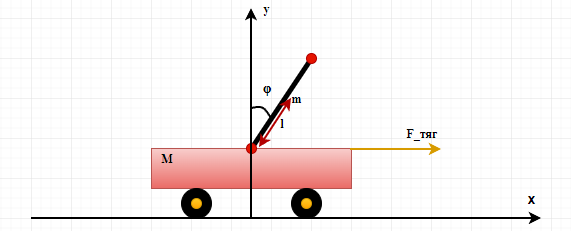

In [323]:
class Parametrs(object):
    def __init__(self):
        self.m = 0.127 # Масса маятника
        self.M = 1.206 # Масса тележки
        self.I = 1.2 * 10**(-3) # Момент инерции относительно центра масс
        self.l = 0.1778 # Расстояние до центра масс
        self.Kf = 1.726 # Конструктивный параметр 
        self.Ks = 4.487 # Конструктивный параметр
        self.Beq = 5.4 # Коэффициент вязкого трения между колесом и направляющей
        self.Bp = 2.4 * 10**(-3) # Коэффициент вязкого трения в точке крепления маятника 
        self.g = 9.81 # Ускорение свободного падения

In [324]:
''' --- Функции --- '''
def continuous_system_coef(p):
    denum = (p.I + p.m * p.l**2) * (p.m + p.M) - p.m**2 * p.l**2
    # ---
    A = np.empty((4, 4))
    A[0] = np.array([0, 0, 1, 0])
    A[1] = np.array([0, 0, 0, 1])
    A[2] = np.array([(p.m + p.M) * p.m * p.g * p.l, 0, -(p.m + p.M) * p.Bp, -p.m * p.l * (p.Kf * p.Ks + p.Beq)]) / denum
    A[3] = np.array([p.m**2 * p.g * p.l**2, 0, -p.m * p.l * p.Bp, -(p.I + p.m * p.l**2) * (p.Kf * p.Ks + p.Beq)]) / denum
    # ---
    B = np.empty((4, 1))
    B[:, 0] = np.array([0, 0, p.m * p.l * p.Kf, (p.I + p.m * p.l**2) * p.Kf]).T / denum
    return A, B

def discrete_const_system_coef(p, h = 1):
    A, B = continuous_system_coef(p)
    Ad = spl.expm(A * h)

    n_mult = 1
    h_mult = 1
    Bd = np.zeros(A.shape)
    var = np.identity(A.shape[0])
    for n in range(1, 12):
        n_mult = n_mult * n
        h_mult = h_mult * h
        Bd = Bd + var * (h_mult / n_mult)
        var = var @ A
    Bd = Bd @ B
    return Ad, Bd

def discrete_impulse_system_coef(p, h = 1):
    A, B = continuous_system_coef(p)
    Ad = spl.expm(A * h)
    Bd = Ad @ B
    return Ad, Bd

def linear_odefun_no_obs(x, t, A, B, theta):
    return (A + B @ theta) @ x

def nonlinear_odefun_no_obs(x, t, p, theta):
    u = theta @ x
    denum = (p.I + p.m * p.l**2) * (p.m + p.M) - p.m**2 * p.l**2 * np.cos(x[0])**2
    # ---
    dxdt = np.empty(x.shape[0])
    dxdt[0] = x[2]
    dxdt[1] = x[3]
    dxdt[2] = (p.m * (p.m + p.M) * p.g * p.l * np.sin(x[0]) + p.m * p.l * np.cos(x[0]) * p.Kf * u 
        - p.Bp * (p.m + p.M) * x[2] - (p.Beq + p.Kf * p.Ks) * p.m * p.l * np.cos(x[0]) * x[3] 
        - p.m * p.l * np.cos(x[0]) * p.m * p.l**2 * x[2]**2 * np.sin(x[0])) / denum
    dxdt[3] = (p.Kf * (p.I + p.m * p.l**2) * u - (p.Kf * p.Ks + p.Beq) * (p.I + p.m * p.l**2) * x[3]
        - (p.I + p.m * p.l**2) * p.m * p.l**2 * x[2]**2 * np.sin(x[0]) - p.m * p.l * np.cos(x[0]) * p.Bp * x[2]
        + p.m**2 * p.l**2 * p.g * np.sin(x[0]) * np.cos(x[0])) / denum
    return dxdt

def linear_odefun_with_obs(y, t, A, B, L, C, theta):
    n = int(y.shape[0] / 2)
    dydt = np.empty(y.shape[0]) # y[:n] - x, y[n:] - \ksi
    # ---
    dydt[:n] = A @ y[:n] + B @ theta @ y[n:]
    dydt[n:] = (A + B @ theta) @ y[n:] + L @ C @ (y[:n] - y[n:])
    return dydt

def nonlinear_odefun_with_obs(y, t, p, L, C, theta):
    n = int(y.shape[0] / 2)
    dydt = np.empty(y.shape[0]) # y[:n] - x, y[n:] - \ksi
    
    u = theta @ y[n:]
    denum = (p.I + p.m * p.l**2) * (p.m + p.M) - p.m**2 * p.l**2 * np.cos(y[0])**2
    # Определяем dx
    dydt[0] = y[2]
    dydt[1] = y[3]
    dydt[2] = (p.m * (p.m + p.M) * p.g * p.l * np.sin(y[0]) + p.m * p.l * np.cos(y[0]) * p.Kf * u 
        - p.Bp * (p.m + p.M) * y[2] - (p.Beq + p.Kf * p.Ks) * p.m * p.l * np.cos(y[0]) * y[3] 
        - p.m * p.l * np.cos(y[0]) * p.m * p.l**2 * y[2]**2 * np.sin(y[0])) / denum
    dydt[3] = (p.Kf * (p.I + p.m * p.l**2) * u - (p.Kf * p.Ks + p.Beq) * (p.I + p.m * p.l**2) * y[3]
        - (p.I + p.m * p.l**2) * p.m * p.l**2 * y[2]**2 * np.sin(y[0]) - p.m * p.l * np.cos(y[0]) * p.Bp * y[2]
        + p.m**2 * p.l**2 * p.g * np.sin(y[0]) * np.cos(y[0])) / denum
    # Определяем d\ksi
    denum = (p.I + p.m * p.l**2) * (p.m + p.M) - p.m**2 * p.l**2 * np.cos(y[4])**2
    # ---
    dydt[4] = y[6]
    dydt[5] = y[7]
    dydt[6] = (p.m * (p.m + p.M) * p.g * p.l * np.sin(y[4]) + p.m * p.l * np.cos(y[4]) * p.Kf * u 
        - p.Bp * (p.m + p.M) * y[6] - (p.Beq + p.Kf * p.Ks) * p.m * p.l * np.cos(y[4]) * y[7] 
        - p.m * p.l * np.cos(y[4]) * p.m * p.l**2 * y[6]**2 * np.sin(y[4])) / denum
    dydt[7] = (p.Kf * (p.I + p.m * p.l**2) * u - (p.Kf * p.Ks + p.Beq) * (p.I + p.m * p.l**2) * y[7]
        - (p.I + p.m * p.l**2) * p.m * p.l**2 * y[6]**2 * np.sin(y[4]) - p.m * p.l * np.cos(y[4]) * p.Bp * y[6]
        + p.m**2 * p.l**2 * p.g * np.sin(y[4]) * np.cos(y[4])) / denum
    dydt[n:] = dydt[n:] + L @ C @ (y[:n] - y[n:])
    return dydt

def discrete_no_obs(x0, t, Ad, Bd, theta):
    x = x0.copy()
    sol = []
    for cur_t in t:
        sol.append(x)
        x = (Ad + Bd @ theta) @ x
    return np.array(sol)

def discrete_with_obs(y0, t, Ad, Bd, Ld, C, theta):
    n = int(y0.shape[0] / 2)
    # ---
    y = y0.copy() # y[:n] - x, y[n:] - \ksi
    y_next = y.copy()
    sol = []
    for cur_t in t:
        sol.append(y)
        y_next[:n] = Ad @ y[:n] + Bd @ theta @ y[n:]
        y_next[n:] = (Ad + Bd @ theta) @ y[n:] + Ld @ C @ (y[:n] - y[n:])
        y = y_next.copy()
    return np.array(sol)

def discrete_with_noise(x0, t, Ad, Bd, C, theta, x0_mean, x0_cov, v_mean, V_cov, w_mean, W_cov):
    x = x0.copy()
    sol = []
    Ac = Ad + Bd @ theta
    x_cor_plus = x0_mean.copy()
    E_plus = x0_cov.copy()
    for cur_t in t:
        sol.append(x)
        x = Ad @ x + Bd @ theta @ x_cor_plus + np.random.multivariate_normal(v_mean, V_cov)
        # ---
        x_cor_minus = Ac @ x_cor_plus + v_mean
        E_minus = Ad @ E_plus @ Ad.T + V_cov
        # ---
        y = C @ x + np.random.multivariate_normal(w_mean, W_cov)
        E_plus = spl.inv(spl.inv(E_minus) + C.T @ spl.inv(W_cov) @ C)
        x_cor_plus = x_cor_minus + E_plus @ C.T @ spl.inv(W_cov) @ (y - C @ x_cor_minus - w_mean)
    return np.array(sol)

def get_control_akkerman(A, B, desired_poly_coef):
    n = A.shape[0]
    # Матрица управляемости
    C = np.empty((n, n))
    C[:, 0] = B[:, 0]
    for i in range(1, n):
        C[:, i] = A @ C[:, i - 1]
    # Характеристический полином
    var = np.identity(n)
    ch_poly = np.zeros((n, n))
    for c in desired_poly_coef[::-1]:
        ch_poly += var * c
        var = var @ A
    # Единичный вектор-строка
    e_n = np.zeros((1, n))
    e_n[0, -1] = 1
    # Матрица обратной связи
    theta = np.empty((1, n))
    theta[0, :] = - e_n @ np.linalg.inv(C) @ ch_poly
    return theta

def get_control_frobenius(A, B, desired_poly_coef):
    cur_poly_coef = np.poly(spl.eigvals(A))
    # ---
    n = A.shape[0]
    # Матрицы в форме фробениуса
    A_new = np.eye(n, n, 1)
    A_new[-1] = np.array(-np.flip(cur_poly_coef[1:]))
    B_new = np.zeros((n, 1))
    B_new[-1, :] = 1
    # Матрица управляемости исходной системы
    C = np.empty((n, n))
    C[:, 0] = B[:, 0]
    for i in range(1, n):
        C[:, i] = A @ C[:, i - 1]
    # Матрица управляемости системы в форме Фробениуса
    C_new = np.empty((n, n))
    C_new[:, 0] = B_new[:, 0]
    for i in range(1, n):
        C_new[:, i] = A_new @ C_new[:, i - 1]
    # ---
    theta_new = np.empty((1, n))
    theta_new[0, :] = np.flip(cur_poly_coef[1:]) - np.flip(desired_poly_coef[1:])
    # Матрица обратной связи
    theta = theta_new @ C_new @ spl.inv(C)
    return theta

def continuous_LQR(A, B, Q, R):
    X = spl.solve_continuous_are(A, B, Q, R)
    return - spl.inv(R) @ B.T @ X

def discrete_LQR(A, B, Q, R):
    X = spl.solve_discrete_are(A, B, Q, R)
    return - spl.inv(R + B.T @ X @ B) @ B.T @ X @ A

def continuous_LMI(A, B, Q):
    n = A.shape[0]
    m = B.shape[1]
    # ---
    X = cp.Variable((n, n), symmetric = True)
    Z = cp.Variable((m ,n))
    # ---
    obj = cp.Minimize(0)
    constr = [X >> 0.01 * np.identity(n)]
    constr += [A @ X + B @ Z + X @ A.T + Z.T @ B.T + Q << 0]
    # ---
    prob = cp.Problem(obj, constr)
    prob.solve()
    return Z.value @ spl.inv(X.value)

def discrete_LMI(Ad, Bd, Q):
    n = Ad.shape[0]
    m = Bd.shape[1]
    # ---
    X = cp.Variable((n, n), symmetric = True)
    Z = cp.Variable((m ,n))
    # ---
    L = np.identity(2)
    M = np.array([[0, 0], [1, 0]])
    # ---
    obj = cp.Minimize(0)
    constr = [X >> 0.01 * np.identity(n)]
    constr += [cp.kron(L, X) + cp.kron(M, Ad @ X + Bd @ Z) + cp.kron(M, Ad @ X + Bd @ Z).T - cp.kron(L, Q) >> 0]
    # ---
    prob = cp.Problem(obj, constr)
    prob.solve()
    return Z.value @ spl.inv(X.value)


def solve_plot(t, sol, u, name = '', color = 'blue'):
    plt.figure(figsize = (16, 12))
    plt.suptitle(name, fontsize = 18)
    layout = (3, 2)
    axes = []
    for i in range(2):
        for j in range(2):
            axes.append(plt.subplot2grid(layout, (i, j)))
    axes.append(plt.subplot2grid(layout, (2, 0), colspan = 2))
    # ---
    axes[0].plot(t, sol[:, 0], label = r'$\varphi$', color = color)
    axes[1].plot(t, sol[:, 1], label = r'$x$', color = color)
    axes[2].plot(t, sol[:, 2], label = r'$\dot{\varphi}$', color = color)
    axes[3].plot(t, sol[:, 3], label = r'$\dot{x}$', color = color)
    axes[4].plot(t, u, label = r'$u$', color = color)
    ylabels = [r'$\varphi$', r'$x$', r'$\dot{\varphi}$', r'$\dot{x}$', r'$u$']
    for i in range(5):
        axes[i].grid(which = 'major')
        axes[i].legend(prop = {'size': 14})
        axes[i].set_xlabel(r'$t$', fontsize = 12)
        axes[i].set_ylabel(ylabels[i], fontsize = 12)
    plt.show()

def solve_plot_with_obs(t, sol, u, name, colors = ['blue', 'red']):
    plt.figure(figsize = (16, 12))
    plt.suptitle(name, fontsize = 18)
    layout = (3, 2)
    axes = []
    for i in range(2):
        for j in range(2):
            axes.append(plt.subplot2grid(layout, (i, j)))
    axes.append(plt.subplot2grid(layout, (2, 0), colspan = 2))
    # ---
    axes[0].plot(t, sol[:, 0], label = r'$\varphi$', color = colors[0])
    axes[0].plot(t, sol[:, 4], label = r'obs_$\varphi$', color = colors[1])
    # ---
    axes[1].plot(t, sol[:, 1], label = r'$x$', color = colors[0])
    axes[1].plot(t, sol[:, 5], label = r'obs_$x$', color = colors[1])
    # ---
    axes[2].plot(t, sol[:, 2], label = r'$\dot{\varphi}$', color = colors[0])
    axes[2].plot(t, sol[:, 6], label = r'obs_$\dot{\varphi}$', color = colors[1])
    # ---
    axes[3].plot(t, sol[:, 3], label = r'$\dot{x}$', color = colors[0])
    axes[3].plot(t, sol[:, 7], label = r'obs_$\dot{x}$', color = colors[1])
    # ---
    axes[4].plot(t, u, label = r'obs_$u$', color = colors[1])
    ylabels = [r'$\varphi$', r'$x$', r'$\dot{\varphi}$', r'$\dot{x}$', r'$u$']
    for i in range(5):
        axes[i].grid(which = 'major')
        axes[i].legend(prop = {'size': 14})
        axes[i].set_xlabel(r'$t$', fontsize = 12)
        axes[i].set_ylabel(ylabels[i], fontsize = 12)
    plt.show()

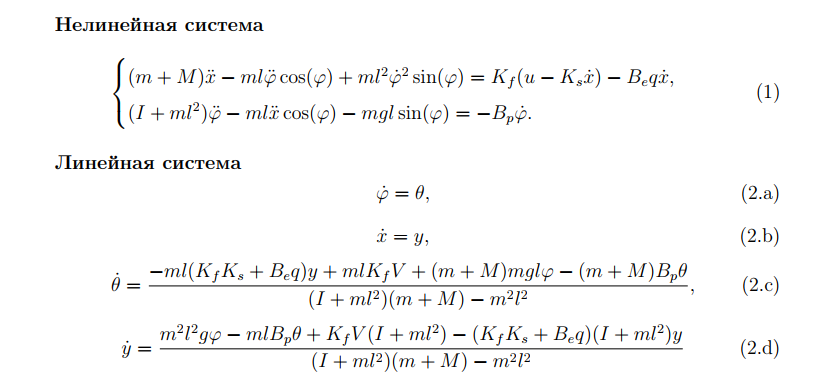
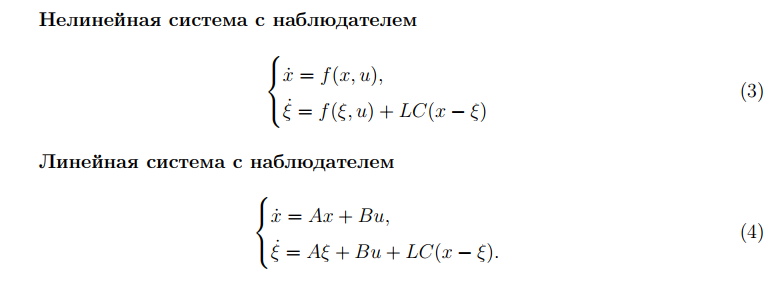
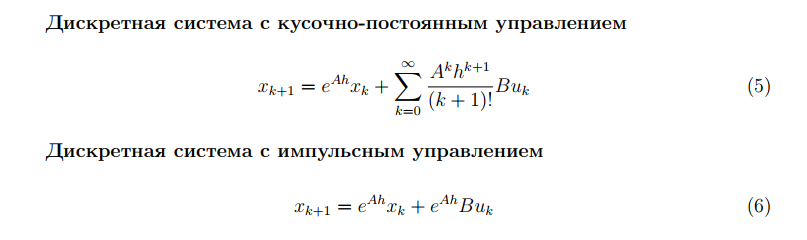

---

# <font color = "black">Формула Аккермана и приведение к форме Фробениуса для непрерывных систем</font>

In [325]:
''' Заполняем матрицы системы и ищем её собственные числа '''
parametrs = Parametrs()
A, B = continuous_system_coef(parametrs)
C = np.array([[1.0, 1.0, 0.0, 0.0]])
eigv_sys = np.array(np.linalg.eigvals(A), dtype = complex)
eigv_obs = eigv_sys.copy()

# --------------------

''' Сдвигаем собственные числа в желаемую область '''
eigv_sys[0:2] = -1.0, -1.0
# theta = get_control_akkerman(A, B, np.poly(eigv_sys))
theta = get_control_frobenius(A, B, np.poly(eigv_sys))
# ---
eigv_obs = eigv_obs.copy()
eigv_obs[0:2] = -10.0, -10.0
# L = -get_control_akkerman(A.T, C.T, np.poly(eigv_obs)).T
L = -get_control_frobenius(A.T, C.T, np.poly(eigv_obs)).T

# --------------------

''' Строим графики '''
t = np.linspace(0, 20, 401)
x0 = np.array([0.3, 0.5, 0.1, 0.2])
ksi0 = np.array([0.3, 0.5, 0.3, 0.5])

# Непрерывная линейная система без наблюдателя
# lin_sol = sig.odeint(linear_odefun_no_obs, x0, t, args = (A, B, theta))
# u = lin_sol @ theta.T
# solve_plot(t, lin_sol, u, 'Linear continuous system, no observer', 'darkblue')

# Непрерывная нелинейная система без наблюдателя
# nonlin_sol = sig.odeint(nonlinear_odefun_no_obs, x0, t, args = (parametrs, theta))
# u = nonlin_sol @ theta.T
# solve_plot(t, nonlin_sol, u, 'Nonlinear continuous system, no observer', 'red')

# Непрерывная линейная система с наблюдателем
# lin_sol_obs = sig.odeint(linear_odefun_with_obs, np.concatenate([x0, ksi0], axis = 0), t, args = (A, B, L, C, theta))
# u = lin_sol_obs[:, 4:] @ theta.T
# solve_plot_with_obs(t, lin_sol_obs, u, 'Linear continuous system with observer', ['darkblue', 'red'])

# Непрерывная нелинейная система с наблюдателем
# nonlin_sol_obs = sig.odeint(nonlinear_odefun_with_obs, np.concatenate([x0, ksi0], axis = 0), t, args = (parametrs, L, C, theta))
# u = nonlin_sol_obs[:, 4:] @ theta.T
# solve_plot_with_obs(t, nonlin_sol_obs, u, 'Nonlinear continuous system with observer', ['darkblue', 'red'])

# <font color = "black">Формула Аккермана и приведение к форме Фробениуса для дискретных систем</font>

In [326]:
''' Заполняем матрицы системы и ищем её собственные числа '''
h = 0.1
parametrs = Parametrs()
Ad, Bd_const = discrete_const_system_coef(parametrs, h)
_, Bd_impulse = discrete_impulse_system_coef(parametrs, h)
C = np.array([[1.0, 1.0, 0.0, 0.0]])

eigv_sys = np.array(np.linalg.eigvals(Ad), dtype = complex)
eigv_obs = eigv_sys.copy()

# --------------------

''' Сдвигаем собственные числа в желаемую область '''
eigv_sys[0:2] = np.exp([-2.0 * h, -2.0 * h])
# theta_const = get_control_akkerman(Ad, Bd_const, np.poly(eigv_sys))
# theta_impulse = get_control_akkerman(Ad, Bd_impulse, np.poly(eigv_sys))
theta_const = get_control_frobenius(Ad, Bd_const, np.poly(eigv_sys))
theta_impulse = get_control_frobenius(Ad, Bd_impulse, np.poly(eigv_sys))
# ---
eigv_obs[0:2] = np.exp([-10.0 * h, -10.0 * h])
# Ld = -get_control_akkerman(Ad.T, C.T, np.poly(eigv_obs)).T
Ld = -get_control_frobenius(Ad.T, C.T, np.poly(eigv_obs)).T

# --------------------

''' Строим графики '''
t = np.linspace(0, 20, 401)
x0 = np.array([0.6, 0.5, -0.4, 0.5])
ksi0 = np.array([0.6, 0.5, 0.4, -0.2])

# Дискретная система с кусочно-постоянным управлением без наблюдателя
# dc_sol = discrete_no_obs(x0, t, Ad, Bd_const, theta_const)
# u = dc_sol @ theta_const.T
# solve_plot(t, dc_sol, u, 'Discrete system with piecewise-const control, no observer', 'darkblue')

# Дискретная система с импульсным управлением без наблюдателя
# di_sol = discrete_no_obs(x0, t, Ad, Bd_impulse, theta_impulse)
# u = di_sol @ theta_impulse.T
# solve_plot(t, di_sol, u, 'Discrete system with impulse control, no observer', 'red')

# Дискретная система с кусочно-постоянным управлением с наблюдателем
# dc_sol_obs = discrete_with_obs(np.concatenate([x0, ksi0], axis = 0), t, Ad, Bd_const, Ld, C, theta_const)
# u = dc_sol_obs[:, 4:] @ theta_const.T
# solve_plot_with_obs(t, dc_sol_obs, u, 'Discrete system with piecewise-const control with observer', ['darkblue', 'red'])

# Дискретная система с импульсным управлением с наблюдателем
# di_sol_obs = discrete_with_obs(np.concatenate([x0, ksi0], axis = 0), t, Ad, Bd_impulse, Ld, C, theta_impulse)
# u = di_sol_obs[:, 4:] @ theta_impulse.T
# solve_plot_with_obs(t, di_sol_obs, u, 'Discrete system with impulse control with observer', ['darkblue', 'red'])


# <font color = "black">Линейно-квадратичное управление для непрерывных систем</font>

In [327]:
''' Заполняем матрицы системы и ищем матрицу обратной связи '''
parametrs = Parametrs()
A, B = continuous_system_coef(parametrs)
# C = np.array([[1.0, 1.0, 0.0, 0.0]]); R_obs = np.array([[1]])
C = np.array([[1., 0., 0., 0.], [0., 1., 0., 0.]]); R_obs = np.array([[1, 0], [0, 1]])
Q = np.diag([1, 1, 1, 1])
R_sys = np.array([[1]])
# ---
theta = continuous_LQR(A, B, Q, R_sys) # Стабилизируем систему
L = -continuous_LQR(A.T, C.T, Q, R_obs).T # Стабилизируем наблюдатель

''' Строим графики '''
t = np.linspace(0, 40, 401)
x0 = np.array([0.57, 0.21, 0.42, -0.35])
ksi0 = np.array([0.6, 0.5, 0.4, -0.2])

# Непрерывная линейная система без наблюдателя
# lin_sol = sig.odeint(linear_odefun_no_obs, x0, t, args = (A, B, theta))
# u = lin_sol @ theta.T
# solve_plot(t, lin_sol, u, 'Linear system LQR, no observer', 'green')

# Непрерывная линейная система без наблюдателя
# non_sol = sig.odeint(nonlinear_odefun_no_obs, x0, t, args = (parametrs, theta))
# u = non_sol @ theta.T
# solve_plot(t, non_sol, u, 'Nonlinear system LQR, no observer', 'purple')

# Непрерывная линейная система с наблюдателя
# lin_sol_obs = sig.odeint(linear_odefun_with_obs, np.concatenate([x0, ksi0], axis = 0), t, args = (A, B, L, C, theta))
# u = lin_sol_obs[:, 4:] @ theta.T
# solve_plot_with_obs(t, lin_sol_obs, u, 'Linear system LQR with observer', ['green', 'purple'])

# Непрерывная линейная система без наблюдателя
# non_sol_obs = sig.odeint(nonlinear_odefun_with_obs, np.concatenate([x0, ksi0], axis = 0), t, args = (parametrs, L, C, theta))
# u = non_sol_obs[:, 4:] @ theta.T
# solve_plot_with_obs(t, non_sol_obs, u, 'Nonlinear system LQR with observer', ['green', 'purple'])


# <font color = "black">Линейно-квадратичное управление для дискретных систем</font>

In [328]:
''' Заполняем матрицы системы и ищем матрицу обратной связи '''
h = 0.1
parametrs = Parametrs()
Ad, Bd_const = discrete_const_system_coef(parametrs, h)
_, Bd_impulse = discrete_impulse_system_coef(parametrs, h)
# C = np.array([[1.0, 1.0, 0.0, 0.0]]); R_obs = np.array([[1]])
C = np.array([[1., 0., 0., 0.], [0., 1., 0., 0.]]); R_obs = np.array([[1, 0], [0, 1]])
Q = np.diag([1, 1, 1, 1])
R_sys = np.array([[1]])
# ---
theta_const = discrete_LQR(Ad, Bd_const, Q, R_sys) # Стабилизируем систему с кусочно-постоянным управлением
theta_impulse = discrete_LQR(Ad, Bd_impulse, Q, R_sys) # Стабилизируем систему с импульсным управлением
# ---
Ld = -discrete_LQR(Ad.T, C.T, Q, R_obs).T # Стабилизируем наблюдатель

''' Строим графики '''
t = np.linspace(0, 40, 401)
x0 = np.array([0.57, 0.21, 0.42, -0.35])
ksi0 = np.array([0.6, 0.5, 0.4, -0.2])

# Дискретная система с кусочно-постоянным управлением без наблюдателя
# dc_sol = discrete_no_obs(x0, t, Ad, Bd_const, theta_const)
# u = dc_sol @ theta_const.T
# solve_plot(t, dc_sol, u, 'Discrete system with piecewise-const and LQR control, no observer', 'orange')

# Дискретная система с импульсным управлением без наблюдателя
# di_sol = discrete_no_obs(x0, t, Ad, Bd_impulse, theta_impulse)
# u = di_sol @ theta_impulse.T
# solve_plot(t, di_sol, u, 'Discrete system with impulse and LQR control, no observer', 'black')

# Дискретная система с кусочно-постоянным управлением с наблюдателем
# dc_sol_obs = discrete_with_obs(np.concatenate([x0, ksi0], axis = 0), t, Ad, Bd_const, Ld, C, theta_const)
# u = dc_sol_obs[:, 4:] @ theta_const.T
# solve_plot_with_obs(t, dc_sol_obs, u, 'Discrete system with piecewise-const and LQR control with observer', ['orange', 'black'])

# Дискретная система с импульсным управлением с наблюдателем
# di_sol_obs = discrete_with_obs(np.concatenate([x0, ksi0], axis = 0), t, Ad, Bd_impulse, Ld, C, theta_impulse)
# u = di_sol_obs[:, 4:] @ theta_impulse.T
# solve_plot_with_obs(t, di_sol_obs, u, 'Discrete system with impulse and LQR control with observer', ['orange', 'black'])


# <font color = "black">Фильтр Калмана для дискретной системы</font>

In [329]:
''' Заполняем матрицы системы и ищем матрицу обратной связи '''
h = 0.1
parametrs = Parametrs()
Ad, Bd_const = discrete_const_system_coef(parametrs, h)
_, Bd_impulse = discrete_impulse_system_coef(parametrs, h)
# C = np.array([[1.0, 1.0, 0.0, 0.0]]); R_obs = np.array([[1]])
C = np.array([[1., 0., 0., 0.], [0., 1., 0., 0.]]); R_obs = np.array([[1, 0], [0, 1]])
Q = np.diag([1, 1, 1, 1])
R_sys = 4
# ---
X = spl.solve_discrete_are(Ad, Bd_const, Q, R_sys) # Стабилизируем систему с кусочно-постоянным управлением
theta_const = - spl.inv(R_sys + Bd_const.T @ X @ Bd_const) @ Bd_const.T @ X @ Ad
# ---
X = spl.solve_discrete_are(Ad, Bd_impulse, Q, R_sys) # Стабилизируем систему с импульсным управлением
theta_impulse = - spl.inv(R_sys + Bd_impulse.T @ X @ Bd_impulse) @ Bd_impulse.T @ X @ Ad
# ---
X = spl.solve_discrete_are(Ad.T, C.T, Q, R_obs) # Стабилизируем наблюдатель
Ld = Ad @ X @ C.T @ spl.inv(R_obs + C @ X @ C.T)

''' Строим графики '''
t = np.linspace(0, 40, 401)
x0 = np.array([0.57, 0.21, 0.42, -0.35])
ksi0 = np.array([0.6, 0.5, 0.4, -0.2])

# Ковариация и среднее для случайных величин
x0_mean = np.array([0.55, 0.2, 0.43, -0.34])
x0_cov = np.identity(4) * 0.01
v_mean = np.zeros(4)
V_cov = np.identity(4) * 0.0001
w_mean = np.zeros(2)
W_cov = np.identity(2) * 0.0001

# Дискретная система с кусочно-постоянным управлением без наблюдателя
# dc_kalman_sol = discrete_with_noise(x0, t, Ad, Bd_const, C, theta_const, x0_mean, x0_cov, v_mean, V_cov, w_mean, W_cov)
# u = dc_kalman_sol @ theta_const.T
# solve_plot(t, dc_kalman_sol, u, 'Discrete system with piecewise-const and LQR control, no observer', 'orange')

# Дискретная система с импульсным управлением без наблюдателя
# di_kalman_sol = discrete_with_noise(x0, t, Ad, Bd_impulse, C, theta_impulse, x0_mean, x0_cov, v_mean, V_cov, w_mean, W_cov)
# u = di_kalman_sol @ theta_impulse.T
# solve_plot(t, di_kalman_sol, u, 'Discrete system with impulse and LQR control, no observer', 'black')


# <font color = "black">Поиск управления с помощью линейно-матричных неравенств для непрерывной системы</font>

In [330]:
''' Заполняем матрицы системы и ищем матрицу обратной связи '''
parametrs = Parametrs()
A, B = continuous_system_coef(parametrs)
# C = np.array([[1.0, 1.0, 0.0, 0.0]])
C = np.array([[1., 0., 0., 0.], [0., 1., 0., 0.]])
Q = np.identity(4) * 10
# ---
theta = continuous_LMI(A, B, Q) # Стабилизируем систему
L = -continuous_LMI(A.T, C.T, Q).T # Стабилизируем наблюдатель

''' Строим графики '''
t = np.linspace(0, 40, 401)
x0 = np.array([0.57, 0.21, 0.42, -0.35])
ksi0 = np.array([0.6, 0.5, 0.4, -0.2])

# Непрерывная линейная система без наблюдателя
# lin_sol = sig.odeint(linear_odefun_no_obs, x0, t, args = (A, B, theta))
# u = lin_sol @ theta.T
# solve_plot(t, lin_sol, u, 'Linear system LQR, no observer', 'green')

# Непрерывная линейная система без наблюдателя
# non_sol = sig.odeint(nonlinear_odefun_no_obs, x0, t, args = (parametrs, theta))
# u = non_sol @ theta.T
# solve_plot(t, non_sol, u, 'Nonlinear system LQR, no observer', 'purple')

# Непрерывная линейная система с наблюдателя
# lin_sol_obs = sig.odeint(linear_odefun_with_obs, np.concatenate([x0, ksi0], axis = 0), t, args = (A, B, L, C, theta))
# u = lin_sol_obs[:, 4:] @ theta.T
# solve_plot_with_obs(t, lin_sol_obs, u, 'Linear system LQR with observer', ['green', 'purple'])

# Непрерывная линейная система без наблюдателя
# non_sol_obs = sig.odeint(nonlinear_odefun_with_obs, np.concatenate([x0, ksi0], axis = 0), t, args = (parametrs, L, C, theta))
# u = non_sol_obs[:, 4:] @ theta.T
# solve_plot_with_obs(t, non_sol_obs, u, 'Nonlinear system LQR with observer', ['green', 'purple'])


# <font color = "black">Поиск управления с помощью линейно-матричных неравенств для дискретной системы</font>

In [331]:
''' Заполняем матрицы системы и ищем матрицу обратной связи '''
h = 0.1
parametrs = Parametrs()
Ad, Bd_const = discrete_const_system_coef(parametrs, h)
_, Bd_impulse = discrete_impulse_system_coef(parametrs, h)
# C = np.array([[1.0, 1.0, 0.0, 0.0]])
C = np.array([[1., 0., 0., 0.], [0., 1., 0., 0.]])
Q = np.identity(4) * 10
# ---
theta_const = discrete_LMI(Ad, Bd_const, Q) # Стабилизируем систему с кусочно-постоянным управлением
theta_impulse = discrete_LMI(Ad, Bd_impulse, Q) # Стабилизируем систему с импульсным управлением
# ---
Ld = -discrete_LMI(Ad.T, C.T, Q).T # Стабилизируем наблюдатель

''' Строим графики '''
t = np.linspace(0, 40, 401)
x0 = np.array([0.57, 0.21, 0.42, -0.35])
ksi0 = np.array([0.6, 0.5, 0.4, -0.2])

# Дискретная система с кусочно-постоянным управлением без наблюдателя
# dc_sol = discrete_no_obs(x0, t, Ad, Bd_const, theta_const)
# u = dc_sol @ theta_const.T
# solve_plot(t, dc_sol, u, 'Discrete system with piecewise-const and LQR control, no observer', 'orange')

# Дискретная система с импульсным управлением без наблюдателя
# di_sol = discrete_no_obs(x0, t, Ad, Bd_impulse, theta_impulse)
# u = di_sol @ theta_impulse.T
# solve_plot(t, di_sol, u, 'Discrete system with impulse and LQR control, no observer', 'black')

# Дискретная система с кусочно-постоянным управлением с наблюдателем
# dc_sol_obs = discrete_with_obs(np.concatenate([x0, ksi0], axis = 0), t, Ad, Bd_const, Ld, C, theta_const)
# u = dc_sol_obs[:, 4:] @ theta_const.T
# solve_plot_with_obs(t, dc_sol_obs, u, 'Discrete system with piecewise-const and LQR control with observer', ['orange', 'black'])

# Дискретная система с импульсным управлением с наблюдателем
# di_sol_obs = discrete_with_obs(np.concatenate([x0, ksi0], axis = 0), t, Ad, Bd_impulse, Ld, C, theta_impulse)
# u = di_sol_obs[:, 4:] @ theta_impulse.T
# solve_plot_with_obs(t, di_sol_obs, u, 'Discrete system with impulse and LQR control with observer', ['orange', 'black'])
